In [6]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import math

In [7]:
pd.set_option('display.max_columns',None)
plt.style.use('seaborn-v0_8-darkgrid')
df = pd.read_csv('GermanCredit.csv')
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,4,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,2,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,3,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,4,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,4,'no known property',53,none,'for free',2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,'no checking',12,'existing paid',furniture/equipment,1736,'<100','4<=X<7',3,'female div/dep/mar',none,4,'real estate',31,none,own,1,'unskilled resident',1,none,yes,good
996,'<0',30,'existing paid','used car',3857,'<100','1<=X<4',4,'male div/sep',none,4,'life insurance',40,none,own,1,'high qualif/self emp/mgmt',1,yes,yes,good
997,'no checking',12,'existing paid',radio/tv,804,'<100','>=7',4,'male single',none,4,car,38,none,own,1,skilled,1,none,yes,good
998,'<0',45,'existing paid',radio/tv,1845,'<100','1<=X<4',4,'male single',none,4,'no known property',23,none,'for free',1,skilled,1,yes,yes,bad


Each row in the dataset corresponds to a loan application by a person in Germany. In this notebook, we will be interested in making a model that predicts the class variable, which is 'good' or 'bad' depending on whether a person is a credit risk.

First we are going to take care of some data cleaning and exploration. Many of the columns have a 'none' entry. 

In [8]:
(df == 'none').sum()

checking_status             0
duration                    0
credit_history              0
purpose                     0
credit_amount               0
savings_status              0
employment                  0
installment_commitment      0
personal_status             0
other_parties             907
residence_since             0
property_magnitude          0
age                         0
other_payment_plans       814
housing                     0
existing_credits            0
job                         0
num_dependents              0
own_telephone             596
foreign_worker              0
class                       0
dtype: int64

other_parties, other_payment_plans, and own_telephone have more none's than anything else. Let's take a look at why this is the case.

In [9]:
df['other_parties'].unique(), df['other_payment_plans'].unique(), df['own_telephone'].unique()

(array(['none', 'guarantor', "'co applicant'"], dtype=object),
 array(['none', 'bank', 'stores'], dtype=object),
 array(['yes', 'none'], dtype=object))

It seems like 'none' means 'no other party' or 'no other payment plan' or 'doesn't own telephone', and not that they are missing values, so we should keep these columns. Let's change them so they are more descriptive than just 'none'. They probably won't cause problems in any case, but why not fix it:

In [10]:
df['other_parties'] = df['other_parties'].replace('none','no_other_parties')
df['other_payment_plans'] = df['other_payment_plans'].replace('none','no_other_payment_plan')
df['own_telephone'] = df['own_telephone'].replace('none','no')
df['other_parties'].unique(), df['other_payment_plans'].unique(), df['own_telephone'].unique()

(array(['no_other_parties', 'guarantor', "'co applicant'"], dtype=object),
 array(['no_other_payment_plan', 'bank', 'stores'], dtype=object),
 array(['yes', 'no'], dtype=object))

Many of the entries in many of the columns have apostrophes. Let's get rid of all of them, no matter where they are in the string.

In [11]:
df = df.map(lambda x: x.replace('\'', '') if isinstance(x, str) else x)
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,no_other_parties,4,real estate,67,no_other_payment_plan,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,no_other_parties,2,real estate,22,no_other_payment_plan,own,1,skilled,1,no,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,no_other_parties,3,real estate,49,no_other_payment_plan,own,1,unskilled resident,2,no,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,no_other_payment_plan,for free,1,skilled,2,no,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,no_other_parties,4,no known property,53,no_other_payment_plan,for free,2,skilled,2,no,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,no_other_parties,4,real estate,31,no_other_payment_plan,own,1,unskilled resident,1,no,yes,good
996,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,no_other_parties,4,life insurance,40,no_other_payment_plan,own,1,high qualif/self emp/mgmt,1,yes,yes,good
997,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male single,no_other_parties,4,car,38,no_other_payment_plan,own,1,skilled,1,no,yes,good
998,<0,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,no_other_parties,4,no known property,23,no_other_payment_plan,for free,1,skilled,1,yes,yes,bad


When we do logistic regression, we are ultimately going to have to replace the class labels with numbers, but for now, let's replace some of the labels to look nicer when we plot them.

In [12]:
checkingMapping = {
    'no checking': 'No_checking_or_unknown',
    '<0': 'Low',
    '0<=X<200': 'Medium',
    '>=200': 'High'
}
savingsMapping = {
    'no known savings': 'No_savings_or_unknown',
    '<100': 'Low',
    '100<=X<500': 'Medium',
    '500<=X<1000': 'High',
    '>=1000': 'Very_high'
}
year_range_mapping = {
    'unemployed': 'Unemployed',
    '<1': 'Less than 1 year',
    '1<=X<4': '1-3 years',
    '4<=X<7': '4-6 years',
    '>=7': '7 years or more'
}
with pd.option_context("future.no_silent_downcasting", True):
    df['checking_status'] = df['checking_status'].replace(checkingMapping)
    df['savings_status'] = df['savings_status'].replace(savingsMapping)
    df['employment'] = df['employment'].replace(year_range_mapping)


df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,Low,6,critical/other existing credit,radio/tv,1169,No_savings_or_unknown,7 years or more,4,male single,no_other_parties,4,real estate,67,no_other_payment_plan,own,2,skilled,1,yes,yes,good
1,Medium,48,existing paid,radio/tv,5951,Low,1-3 years,2,female div/dep/mar,no_other_parties,2,real estate,22,no_other_payment_plan,own,1,skilled,1,no,yes,bad
2,No_checking_or_unknown,12,critical/other existing credit,education,2096,Low,4-6 years,2,male single,no_other_parties,3,real estate,49,no_other_payment_plan,own,1,unskilled resident,2,no,yes,good
3,Low,42,existing paid,furniture/equipment,7882,Low,4-6 years,2,male single,guarantor,4,life insurance,45,no_other_payment_plan,for free,1,skilled,2,no,yes,good
4,Low,24,delayed previously,new car,4870,Low,1-3 years,3,male single,no_other_parties,4,no known property,53,no_other_payment_plan,for free,2,skilled,2,no,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,No_checking_or_unknown,12,existing paid,furniture/equipment,1736,Low,4-6 years,3,female div/dep/mar,no_other_parties,4,real estate,31,no_other_payment_plan,own,1,unskilled resident,1,no,yes,good
996,Low,30,existing paid,used car,3857,Low,1-3 years,4,male div/sep,no_other_parties,4,life insurance,40,no_other_payment_plan,own,1,high qualif/self emp/mgmt,1,yes,yes,good
997,No_checking_or_unknown,12,existing paid,radio/tv,804,Low,7 years or more,4,male single,no_other_parties,4,car,38,no_other_payment_plan,own,1,skilled,1,no,yes,good
998,Low,45,existing paid,radio/tv,1845,Low,1-3 years,4,male single,no_other_parties,4,no known property,23,no_other_payment_plan,for free,1,skilled,1,yes,yes,bad


Moving on,

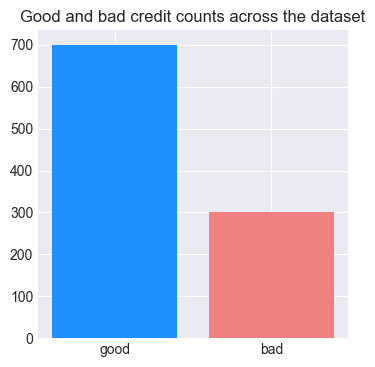

In [13]:
plt.figure(figsize=(4,4))
class_counts = df['class'].value_counts()
plt.bar(class_counts.index,class_counts.values,color=['dodgerblue','lightcoral'])
plt.title('Good and bad credit counts across the dataset')
plt.show()

There are a lot more people with good credit risk than bad credit risk in the dataset. To be precise,

In [14]:
class_counts = df['class'].value_counts()
class_counts

class
good    700
bad     300
Name: count, dtype: int64

Of all the rows in the data, 3/10 are bad and 7/10 are good. Let's plot every column against class. The number above each pair of bars is (#bad)/(#bad+#good).

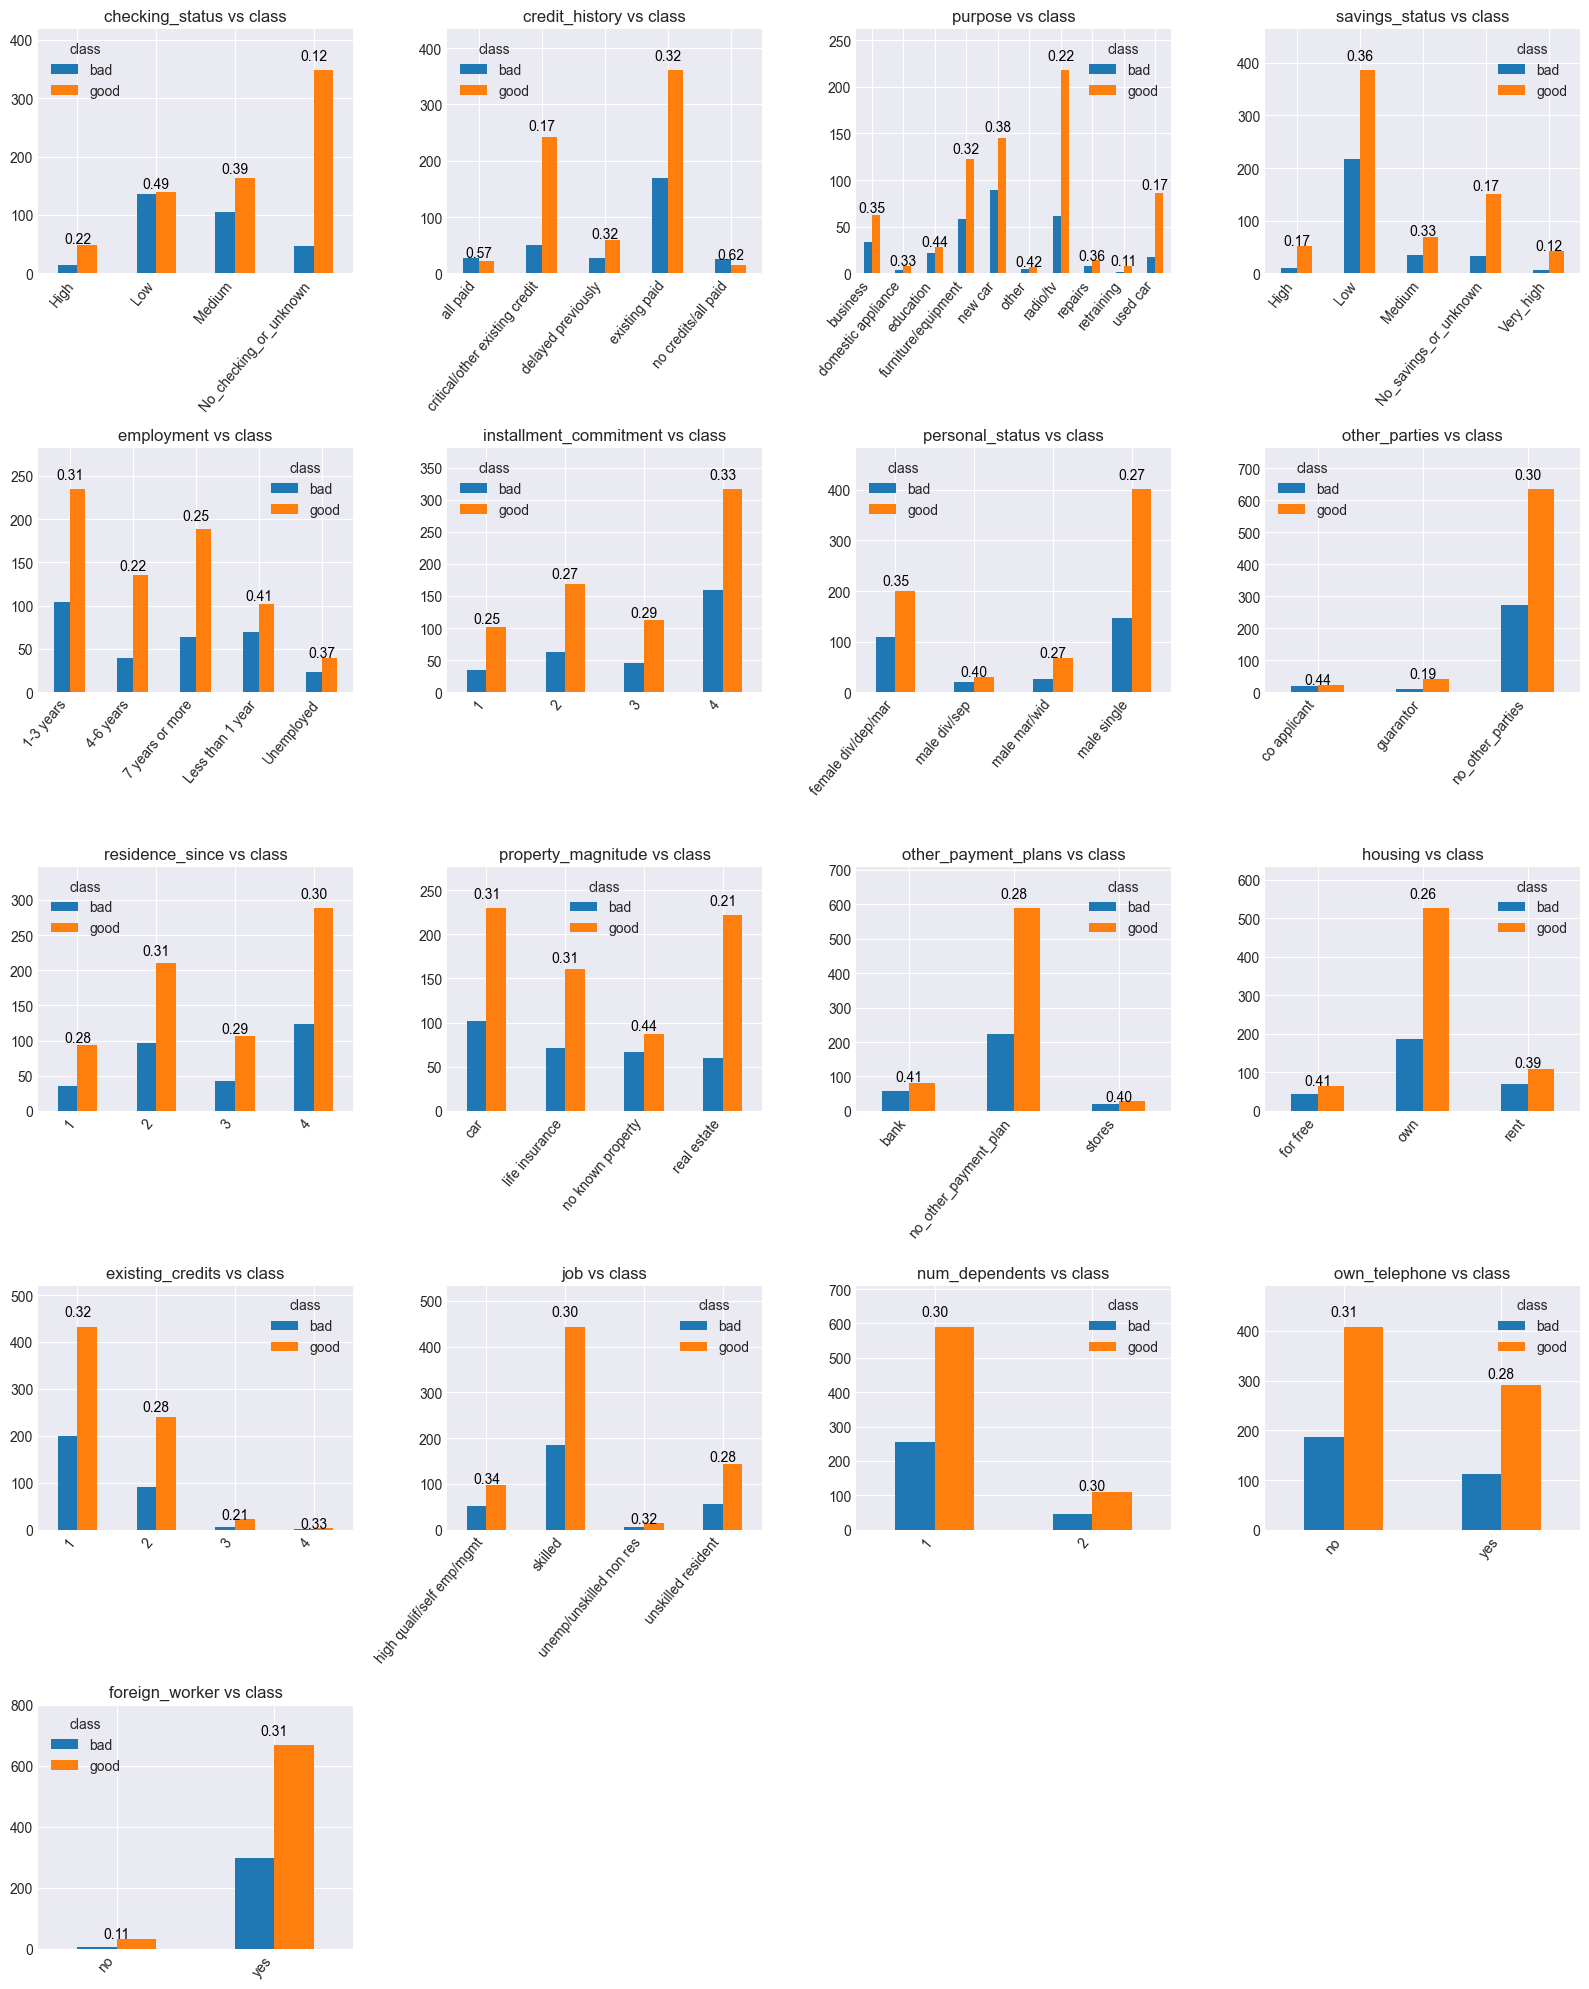

In [15]:
noncatvariables = ['duration', 'credit_amount', 'age']
categorical_cols = [col for col in df.columns if col not in noncatvariables and col != 'class']

num_plots = len(categorical_cols)
fig, axes = plt.subplots(nrows=(num_plots // 4) + 1, ncols=min(4, num_plots), figsize=(16, (num_plots // 4 + 1) * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    counts = df.groupby([col, 'class']).size().unstack(fill_value=0)
    counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{col} vs class")
    axes[i].set_xlabel('')
    axes[i].set_ylabel("")
    axes[i].legend(title="class")
    axes[i].set_ylim(0, counts.max().max() * 1.2)
    axes[i].tick_params(axis='x')
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(50)
        tick.set_ha('right')  
    for j, category in enumerate(counts.index):
        values = counts.loc[category].values
        if len(values) == 2 and values[1] != 0:
            ratio = values[0] /(values[0]+values[1])
            axes[i].text(j, max(values) * 1.05, f"{ratio:.2f}", ha='center', fontsize=10, color='black')  
for j in range(num_plots, len(axes)):
    axes[j].set_visible(False)  

plt.tight_layout()
plt.show()

The first idea we will try for our model is logistic regression. There are a lot of candidates for features. In an effort to throw some of them out, I will make up this criteria: We will keep a feature if it has a ratio outside of [.25,.35] for at least one of the values it takes on, and this value must have at least (eyeballing it) more than 30 observations. We want to pick variables that have explanatory power, where the bad/good ratio varies outside of what it is in the dataset, and varies across categories. Using this criteria, we can throw out all except: 

checking_status, credit_history, purpose, savings_status, employment, property_magnitude, other_payment_plans, housing.

Now let's take a look at the numerical variable: duration, credit_amount, and age.



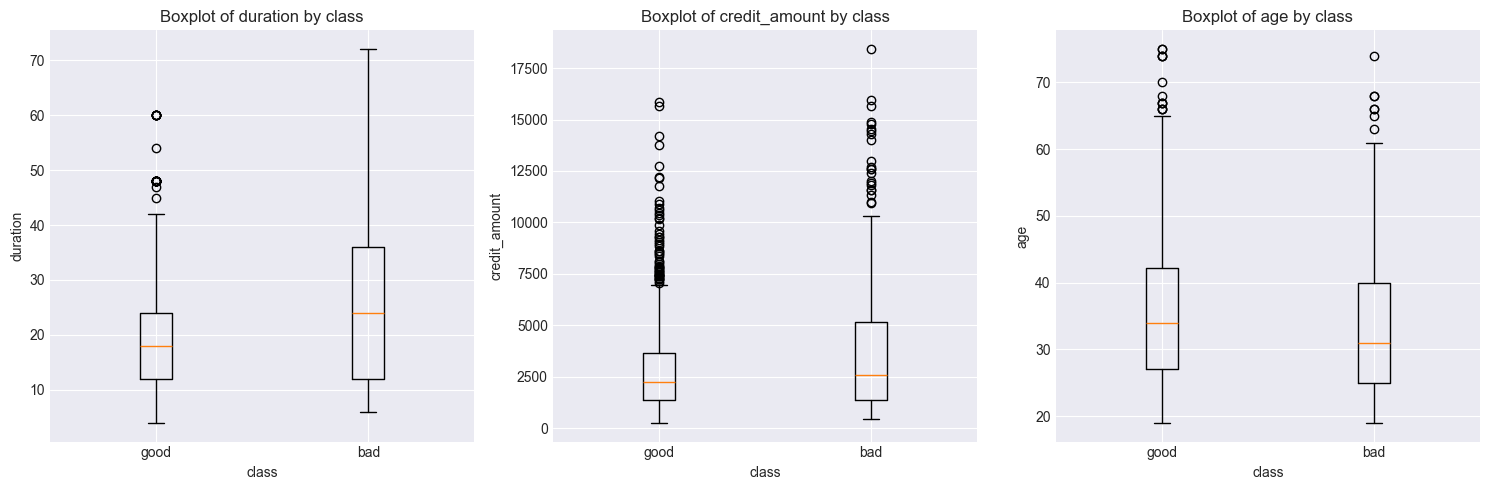

In [16]:
num_cols = ['duration', 'credit_amount', 'age']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(num_cols):
    axes[i].boxplot([df[df['class'] == 'good'][col], df[df['class'] == 'bad'][col]], tick_labels=['good', 'bad'])
    axes[i].set_title(f'Boxplot of {col} by class')
    axes[i].set_xlabel('class')
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

For duration and credit_amount, the 'bad' boxes are stretched upwards, and there are more bad data points at higher values. But let's look at another visualization just to be sure. The difference between good and bad is slightly less pronounced in the age graph. Let's keep the first two variables in the model.

The next task is mapping the categorical values to numbers. Some categories (like checking_status) have a natural ordering, while others do not. For the ones with an ordering, we will label the classes 0,1,2,... and for the non-ordered classes we will use one hot encoding.

In [17]:
import sklearn.metrics
import sklearn.preprocessing

features = ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'property_magnitude', 'other_payment_plans', 'housing','duration','credit_amount','class']
nonorderedcat = ['credit_history','purpose','property_magnitude','other_payment_plans','housing','class']
orderedcat = ['checking_status','savings_status','employment']
numerical = ['duration','credit_amount']
df_one_hot = pd.get_dummies(df[nonorderedcat],drop_first=False,dtype='float')
ordered_categories = [['Low','Medium','High','No_checking_or_unknown'],
                      ['Low','Medium','High','Very_high','No_savings_or_unknown'],
                      ['Unemployed','Less than 1 year','1-3 years','4-6 years','7 years or more']]
newdf = df[orderedcat]
ordinal_encoder = sklearn.preprocessing.OrdinalEncoder(categories=ordered_categories)
newdf = ordinal_encoder.fit_transform(newdf)
newdf = pd.DataFrame(newdf,columns=orderedcat)
newdf = pd.concat([newdf, df_one_hot,df[numerical]], axis=1)
newdf = newdf.drop('class_bad',axis=1)
newdf

,checking_status,savings_status,employment,credit_history_all paid,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,purpose_business,purpose_domestic appliance,purpose_education,purpose_furniture/equipment,purpose_new car,purpose_other,purpose_radio/tv,purpose_repairs,purpose_retraining,purpose_used car,property_magnitude_car,property_magnitude_life insurance,property_magnitude_no known property,property_magnitude_real estate,other_payment_plans_bank,other_payment_plans_no_other_payment_plan,other_payment_plans_stores,housing_for free,housing_own,housing_rent,class_good,duration,credit_amount
0,0.0,4.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,6,1169
1,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,48,5951
2,3.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,12,2096
3,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,42,7882
4,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,24,4870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,12,1736
996,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,30,3857
997,3.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,12,804
998,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,45,1845


Now we have a nice numerical dataframe that we can perform logistic regression on. Let's do that.

In [24]:
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
import sklearn.linear_model
import sklearn.metrics

def conf_matrix(cm):
    print('Confusion matrix: \n', cm)
    print('Accuracy: ',(cm[(0,0)]+cm[(1,1)])/cm.sum())
    print('Accuracy on good datapoints: ',cm[(1,1)]/(cm[(1,0)]+cm[(1,1)]))
    print('Accuracy on bad datapoints: ',cm[(0,0)]/(cm[(0,0)]+cm[(0,1)]))

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    newdf.drop('class_good',axis=1), newdf['class_good'], test_size=0.1, random_state=0
)
lr = sklearn.linear_model.LogisticRegression(max_iter=1000000)
lr.fit(x_train,y_train)
y_test_pred = lr.predict(x_test)
cm = sklearn.metrics.confusion_matrix(y_test,y_test_pred)
conf_matrix(cm)


Confusion matrix: 
 [[12 13]
 [15 60]]
Accuracy:  0.72
Accuracy on good datapoints:  0.8
Accuracy on bad datapoints:  0.48


The interpretaton of the confusion matrix and each of the confusion matrices to come are:

[[True Negative, False Positive],

[False Negative, True Positive]]


The success rate on the test data is 72%. It is important to note that .7 of the dataset is marked as "good", and in the test data set, 75 are marked as "good". So this model actually did worse on the test set than if it guessed "good" on everything. Let's see how the model fit to the training set:

In [25]:
cm = sklearn.metrics.confusion_matrix(y_train,lr.predict(x_train))
conf_matrix(cm)

Confusion matrix: 
 [[148 127]
 [ 68 557]]
Accuracy:  0.7833333333333333
Accuracy on good datapoints:  0.8912
Accuracy on bad datapoints:  0.5381818181818182


 On the training set, the model has not learned to predict 'good' for everything. Something more complicated is going on, although the model has prioritized accuracy on 'good' datapoints rather than accuracy on 'bad' datapoints. 
 
 
 An important factor for usefulness of the model is how confident it is when it gets it wrong or right. If it's correct on the classifications it is very confident on, then this increases the usefulness of the model, since the model will be more reliable in the times it predicts something confidently.

In [37]:
y_test_prob = lr.predict_proba(x_test)[:, 1]
i = .4
while i>.06:
    j = 0
    cm = np.zeros((2,2))
    for val in y_test.items():
        if abs(y_test_prob[j]-.5)>=i:
            if y_test[val[0]]==y_test_pred[j]:
                if y_test[val[0]]==1.0:
                    cm[(1,1)]+=1
                else:
                    cm[(0,0)]+=1
            else:
                if y_test[val[0]]==0.0:
                    cm[(0,1)]+=1
                else:
                    cm[(1,0)]+=1
        j+=1
    print('Threshold: ',round(i,2))
    conf_matrix(cm)
    print('\n')    
    i-=.05


Threshold:  0.4
Confusion matrix: 
 [[ 0.  4.]
 [ 0. 18.]]
Accuracy:  0.8181818181818182
Accuracy on good datapoints:  1.0
Accuracy on bad datapoints:  0.0


Threshold:  0.35
Confusion matrix: 
 [[ 0.  5.]
 [ 0. 26.]]
Accuracy:  0.8387096774193549
Accuracy on good datapoints:  1.0
Accuracy on bad datapoints:  0.0


Threshold:  0.3
Confusion matrix: 
 [[ 1.  5.]
 [ 2. 33.]]
Accuracy:  0.8292682926829268
Accuracy on good datapoints:  0.9428571428571428
Accuracy on bad datapoints:  0.16666666666666666


Threshold:  0.25
Confusion matrix: 
 [[ 4.  5.]
 [ 3. 38.]]
Accuracy:  0.84
Accuracy on good datapoints:  0.926829268292683
Accuracy on bad datapoints:  0.4444444444444444


Threshold:  0.2
Confusion matrix: 
 [[ 7.  8.]
 [ 5. 43.]]
Accuracy:  0.7936507936507936
Accuracy on good datapoints:  0.8958333333333334
Accuracy on bad datapoints:  0.4666666666666667


Threshold:  0.15
Confusion matrix: 
 [[ 7.  9.]
 [ 7. 48.]]
Accuracy:  0.7746478873239436
Accuracy on good datapoints:  0.8727272727

If the threshold is t, then the accuracy here is for all test data points that when inputted into the model give a probability that is more than t away from .5. In other words, when the model is more confident, on this specific slice of data, accuracy does actually go up. Taking t=.25, we see that when the model returns a probability in $[0,.25]\cup[.75,1]$, its accuracy is .84, which is higher than the test accuracy we got for the model in general. 

We can also see that the model is most confident when it is predicting "good".

 While there is a lot more that can be done in terms of feature selection, let's see if we can do better using a different method. Since we are working with lots of categorical data, the dataset might lend itself to being modeled with decision trees. Let's give that a shot.

In [41]:
from sklearn.tree import DecisionTreeClassifier,export_text

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    newdf.drop('class_good',axis=1), newdf['class_good'], test_size=0.1, random_state=0
)
sktree = DecisionTreeClassifier()
sktree.fit(x_train,y_train)
cm = sklearn.metrics.confusion_matrix(y_test,sktree.predict(x_test))
print('TEST RESULTS: ')
conf_matrix(cm)
print('Tree depth: ',sktree.get_depth())
print('Tree leaves: ',sktree.get_n_leaves())

TEST RESULTS: 
Confusion matrix: 
 [[12 13]
 [23 52]]
Accuracy:  0.64
Accuracy on good datapoints:  0.6933333333333334
Accuracy on bad datapoints:  0.48
Tree depth:  19
Tree leaves:  200


Using the settings out of the box, with the same features we chose for logistic regression, did not give great results on test data - we got lower accuracy than we did with logistic regression. Here are the training data results.

In [54]:
cm = sklearn.metrics.confusion_matrix(y_train,sktree.predict(x_train))
print('Training confusion matrix: \n',cm)
print('Train accuracy: ',(cm[(0,0)]+cm[(1,1)])/cm.sum())
print('Tree depth: ',sktree.get_depth())
print('Tree leaves: ',sktree.get_n_leaves())

Training confusion matrix: 
 [[275   0]
 [  0 625]]
Train accuracy:  1.0
Tree depth:  19
Tree leaves:  199


With no restrictions on the tree, the tree overfit to the data, and our model is not generalizing well. Maybe some restrictions on the tree size will lead to some better results.

In [55]:
from sklearn.tree import DecisionTreeClassifier

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    newdf.drop('class_good',axis=1), newdf['class_good'], test_size=0.1, random_state=0
)
sktree = DecisionTreeClassifier(max_leaf_nodes=150,max_depth=15,max_features=12, min_samples_split=5,random_state=1)
sktree.fit(x_train,y_train)
cm = sklearn.metrics.confusion_matrix(y_test,sktree.predict(x_test))
print('Test confusion matrix: \n', cm)
print('Test accuracy: ',(cm[(0,0)]+cm[(1,1)])/cm.sum())
cm = sklearn.metrics.confusion_matrix(y_train,sktree.predict(x_train),)
print('Training confusion matrix: \n',cm)
print('Train accuracy: ',(cm[(0,0)]+cm[(1,1)])/cm.sum())
print('Tree depth: ',sktree.get_depth())
print('Tree leaves: ',sktree.get_n_leaves())

Test confusion matrix: 
 [[19  6]
 [20 55]]
Test accuracy:  0.74
Training confusion matrix: 
 [[247  28]
 [ 39 586]]
Train accuracy:  0.9255555555555556
Tree depth:  15
Tree leaves:  150


This was the result of trying some different settings and seeing what worked. Here, we got 74% accuracy on the test set, which is better than what we got with logistic regression. However, big disclaimer: Many random states were tried with much worse results. So while this tree that I landed on might truly be a better tree than the others, it's also possible that it got lucky with the test set. On average, the results with decision trees were worse than with logistic regression.

For fun, let's try one last avenue. Let's fire up a neural net and see what happens. I don't want to get too crazy here, with a super complicated model. The logistic regression we did was already a simple neural net. Let's try just two layers, to see if the class variable can explained by some slightly more complicated nonlinear relationships.

In [56]:
import torch

class ClassPredictionNetWork(torch.nn.Module):
  def __init__(self):
    super(ClassPredictionNetWork, self).__init__()
    self.linear = torch.nn.Linear( in_features= 30, out_features= 30, bias = True)
    self.linear_2 = torch.nn.Linear( in_features = 30, out_features = 2, bias = True )

  def forward(self, input_tensor):
    flattened = torch.nn.Flatten()( input_tensor )
    layer1 = self.linear( flattened )
    prelogits = torch.nn.ReLU()(layer1)
    logit = self.linear_2( prelogits )
    probabilities = torch.nn.Softmax( dim = 1 )( logit )
    return logit, probabilities


In [57]:
model = ClassPredictionNetWork()
optimizer = torch.optim.Adam( model.parameters(), lr = 0.01 )
loss_function = torch.nn.CrossEntropyLoss()
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    newdf.drop('class_good',axis=1), newdf['class_good'], test_size=0.1, random_state=0
)
nparray = x_train.values.astype(np.float32)
nparray2 = x_test.values.astype(np.float32)
nparray3 = y_train.values.astype('long')
nparray4 = y_test.values.astype('long')
x_train_nn = torch.tensor(nparray)
x_test_nn = torch.tensor(nparray2)
y_train_nn = torch.tensor(nparray3)
y_test_nn = torch.tensor(nparray4)

In [58]:
import random

def get_batch( x, y,  batch_size ):
  n = x.shape[0]
  batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )
  x_batch = x[ batch_indices ]
  y_batch = y[ batch_indices ]
  return x_batch, y_batch

In [59]:
batch_size = 64
for epochs in range(1000):
  total_loss = 0
  for batch in range( x_train_nn.size()[0]//batch_size ):
    x_batch, y_batch, = get_batch( x_train_nn, y_train_nn, batch_size )
    optimizer.zero_grad()
    logits, probabilities = model( x_batch )
    loss = loss_function(logits, y_batch)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  avgloss = total_loss / ( x_train_nn.size()[0] // batch_size )
  if epochs%100==99:
    print("Average Loss per Data Point:", avgloss  )
  

Average Loss per Data Point: 0.4735279913459505
Average Loss per Data Point: 0.5016268427882876
Average Loss per Data Point: 0.4799819886684418
Average Loss per Data Point: 0.4886217159884317
Average Loss per Data Point: 0.48939450085163116
Average Loss per Data Point: 0.5135200172662735
Average Loss per Data Point: 0.45422129120145527
Average Loss per Data Point: 0.5218348843710763
Average Loss per Data Point: 0.4733739175966808
Average Loss per Data Point: 0.5145790300198964


In [60]:
#Some old code that I had. Easier than trying to convert tensors into dataframes and what not.
def confusion_matrix(model, x, y):
  model.eval() 
  identification_counts = np.zeros( shape = (2,2), dtype = np.int32 )
  logits, probabilities = model( x )
  predicted_classes = torch.argmax( probabilities, dim = 1 )
  for i in range(x.size()[0]):
    actual_class = y[i]
    predicted_class = predicted_classes[i].item()
    identification_counts[ actual_class, predicted_class ] += 1
  total_correct = 0
  for i in range(2):
    total_correct += identification_counts[i, i] 
  accuracy = total_correct / np.sum( identification_counts )
  print(identification_counts, 'Accuracy: ', accuracy)

In [61]:
print('Train results: ')
print(confusion_matrix(model,x_train_nn,y_train_nn))
print('Test results: ')
print(confusion_matrix(model,x_test_nn,y_test_nn))

Train results: 
[[134 141]
 [ 64 561]] Accuracy:  0.7722222222222223
None
Test results: 
[[12 13]
 [11 64]] Accuracy:  0.76
None


A modest improvement on the training data and test data. But overall, this neural net is not far off from the logistic model.

Let's try an experiment. All of the models have been trained on the same data, and tested on the same test set. Let's look at the test set and see if it means anything if all three models return 'good' for a data point, or if two models return 'good' for a datapoint. We will also include data about precision rates; this may be useful since a false positive can be costly.

In [77]:
testdf = model(x_test_nn)[1].detach().numpy()
nnresults = np.where(testdf[:,1]<.5,0,1)
lrresults = lr.predict(x_test)
dtresults = sktree.predict(x_test)
results = y_test
combined_array = np.column_stack([nnresults,lrresults,dtresults,results])
cols_1_3 = combined_array[:, :3]
col_4 = combined_array[:, 3]
models = ['Logistic','Decision Tree','Neural Net']
for i in range(3):
    condition = combined_array[:,i]==1
    prob = np.mean(col_4[condition])
    print(f"P(actual value is good | {models[i]} model says good) = {prob}")

condition1 = np.sum(cols_1_3, axis=1) >= 2
prob1 = np.mean(col_4[condition1])
condition2 = np.sum(cols_1_3, axis=1) == 3
prob2 = np.mean(col_4[condition2])
print(f"P(actual value is good | at least two models say good) = {prob1:.4f}")
print(f"P(actual value is good | all three models say good) = {prob2:.4f}")
condition1 = np.sum(cols_1_3, axis=1) <= 1
prob1 = 1-np.mean(col_4[condition1])
condition2 = np.sum(cols_1_3, axis=1) == 0
prob2 = 1-np.mean(col_4[condition2])
print(f"P(actual value is bad | at least two models say bad) = {prob1:.4f}")
print(f"P(actual value is bad | all three models say bad) = {prob2:.4f}")

P(actual value is good | Logistic model says good) = 0.8311688311688312
P(actual value is good | Decision Tree model says good) = 0.821917808219178
P(actual value is good | Neural Net model says good) = 0.9016393442622951
P(actual value is good | at least two models say good) = 0.8421
P(actual value is good | all three models say good) = 0.9057
P(actual value is bad | at least two models say bad) = 0.5417
P(actual value is bad | all three models say bad) = 0.5556


In [75]:
condition1 = combined_array[:,2]==1
prob = np.mean(col_4[condition1])
prob

0.9016393442622951

First off, our precision rates are better than our accuracy. This is good to know, since our model may help us avoid costly false positives. Something to keep in mind though is that because of how good/bad are distributed through the dataset, a model guessing 'good' for everything would have about 70% precision on the data. This does offer an improvement though.

If all of our models classify a datapoint as 'good', and if the results of our test is indicative at all of the general case, then we can be confident that the true value for the datapoint is actually good. We get good results too when at least two of our models say a datapoint is 'good'. Some skepticism is needed, because the test set is only 100 data points, and our result may be partly luck. The models do not do as good of a job telling when a datapoint is 'bad'.

# Miscellaneous Data Exploration

In [63]:
employmentSavingsTable = pd.crosstab(df['employment'], df['savings_status'])
employment = ['Unemployed','Amateur','Experienced','Professional','Expert']
savings_status = ['Low','Medium','High','Very_high','No_savings']
employmentSavingsTable = employmentSavingsTable.reindex(employment,axis='rows')
employmentSavingsTable = employmentSavingsTable.reindex(savings_status,axis='columns')
employmentSavingsTable

savings_status,Low,Medium,High,Very_high,No_savings
employment,,,,,
Unemployed,40,7,3,0,NaN
Amateur,120,17,5,7,NaN
Experienced,210,33,26,18,NaN
Professional,100,24,9,9,NaN
Expert,133,22,20,14,NaN


No matter what their employment status, chances are a person has low savings. A lot have no savings too. There don't seem to be obvious trends; like for example, we'd expect 'expert' to have more savings in general, but this isn't really the case.

/var/folders/p0/_rv7hyx175s58w5dhg463z8w0000gn/T/ipykernel_58468/2227051783.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(personalStats)))


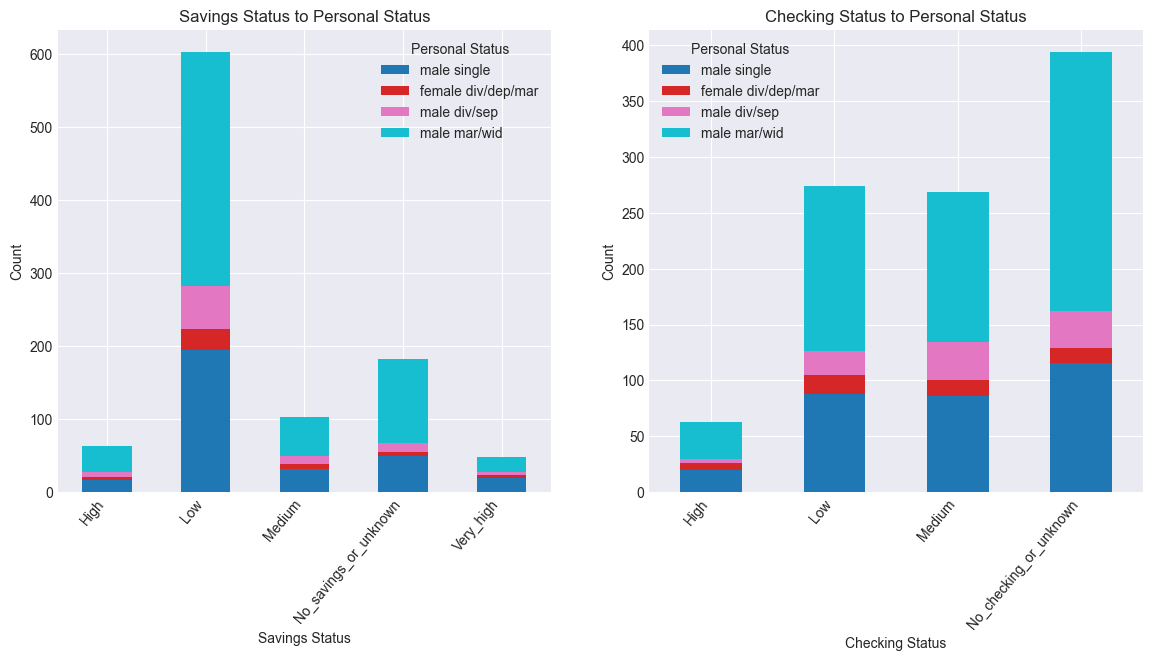

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
personalStats = df['personal_status'].unique()
colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(personalStats)))
savingsStats = df.groupby(['savings_status', 'personal_status']).size().unstack()
savingsStats.plot(kind='bar', stacked=True, ax=axes[0], color=colors)
axes[0].set_title('Savings Status to Personal Status')
axes[0].set_xlabel('Savings Status')
axes[0].set_ylabel('Count')
axes[0].legend(title='Personal Status', labels=personalStats)
for tick in axes[0].get_xticklabels():
        tick.set_rotation(50)
        tick.set_ha('right')  
checkingStats = df.groupby(['checking_status', 'personal_status']).size().unstack()
checkingStats.plot(kind='bar', stacked=True, ax=axes[1], color=colors)
axes[1].set_title('Checking Status to Personal Status')
axes[1].set_xlabel('Checking Status')
axes[1].set_ylabel('Count')
axes[1].legend(title='Personal Status', labels=personalStats)
for tick in axes[1].get_xticklabels():
        tick.set_rotation(50)
        tick.set_ha('right')  
plt.show()

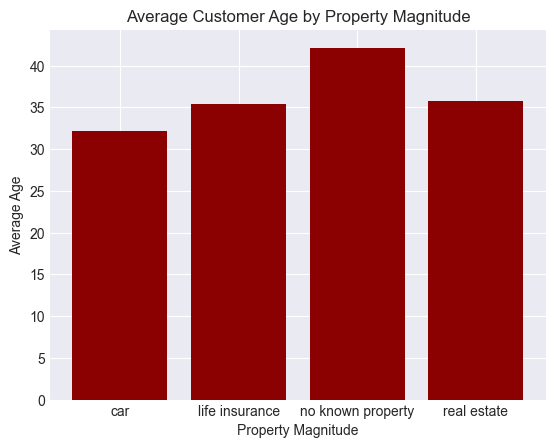

In [65]:
reduced = df[df['credit_amount'] > 4000]
averageAgeByProperty = reduced.groupby('property_magnitude')['age'].mean()
plt.bar(averageAgeByProperty.index, averageAgeByProperty.values,color='darkred')
plt.title('Average Customer Age by Property Magnitude')
plt.xlabel('Property Magnitude')
plt.ylabel('Average Age')
plt.show()


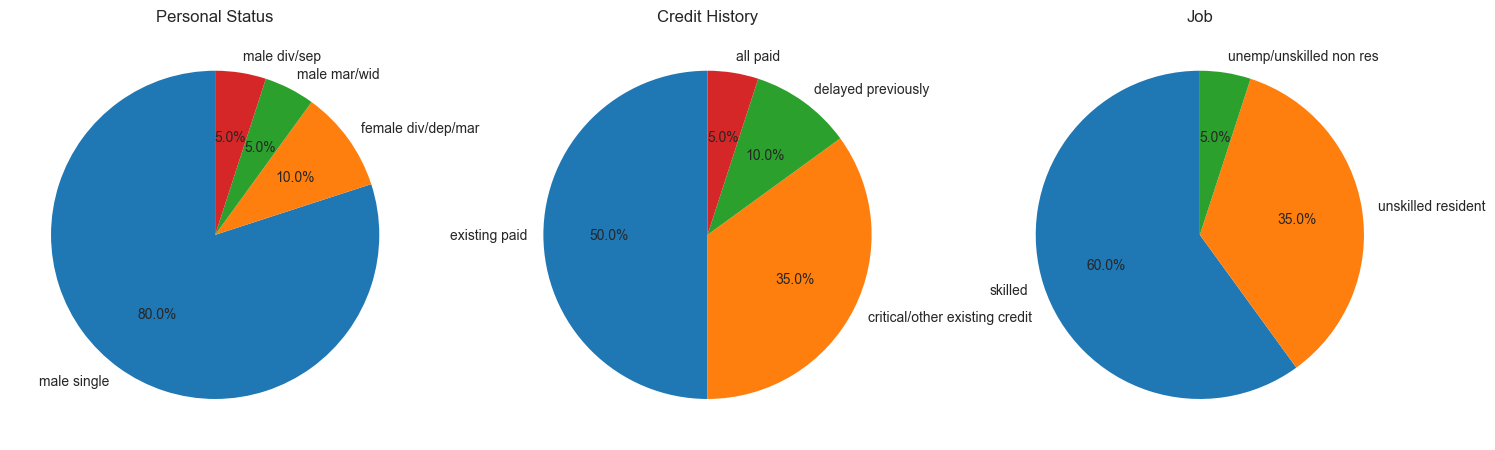

In [66]:
reduced = df[(df['savings_status'] == 'High') & (df['age'] > 40)]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
personalCounts = reduced['personal_status'].value_counts()
axes[0].pie(personalCounts, labels=personalCounts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Personal Status')
creditCounts = reduced['credit_history'].value_counts()
axes[1].pie(creditCounts, labels=creditCounts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Credit History')
jobCounts = reduced['job'].value_counts()
axes[2].pie(jobCounts, labels=jobCounts.index, autopct='%1.1f%%', startangle=90)
axes[2].set_title('Job')
plt.show()